## I. Датасет

In [1]:
from mnist import load_mnist

train, validation, test = load_mnist()

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


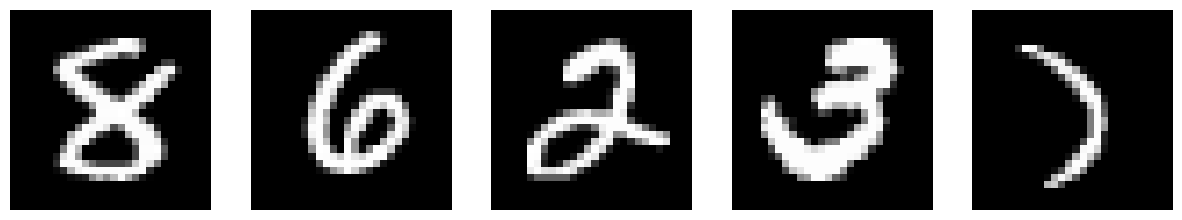

In [35]:
import matplotlib.pyplot as plt
import numpy as np

X_train = train[0]
labels_train = train[1]

X_val = validation[0]
labels_val = validation[1]

X_test = test[0]
labels_test = test[1]


num_images = 5
random_indices = np.random.choice(len(X_train), size=num_images)

fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i, idx in enumerate(random_indices):
    axes[i].imshow(X_train[idx].reshape(28, 28), cmap='gray')
    axes[i].axis('off')

plt.show()

## II. Алгоритм PCA

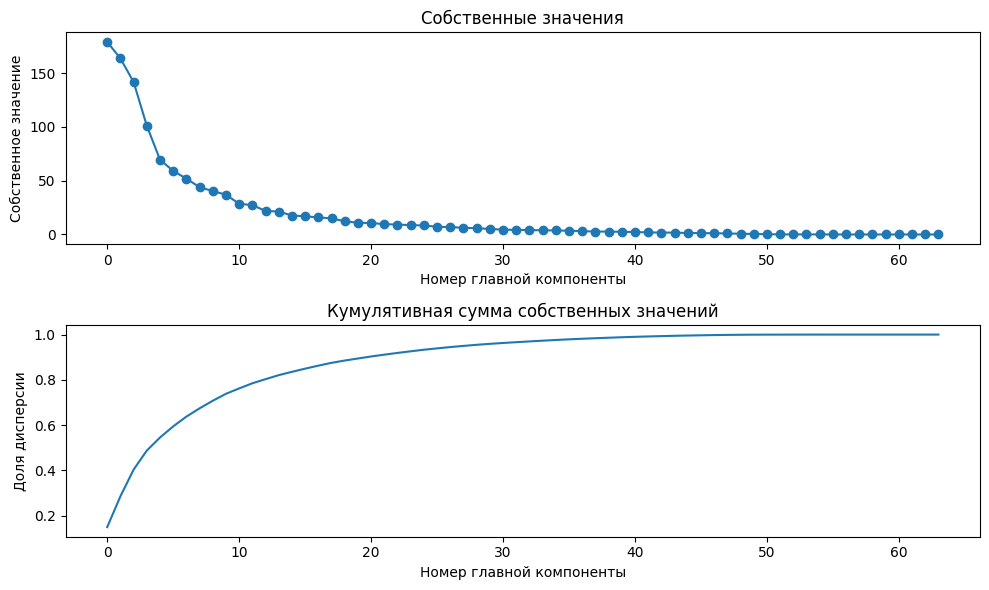

Доля дисперсии, покрываемая первыми 15 главными компонентами: 0.84


/var/folders/vt/1_33k3fx71sdxz3q5nb3qhtw0000gn/T/ipykernel_97130/2487467078.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X_pca[:, 0], X_pca[:, 1], c=digits.target, cmap=plt.cm.get_cmap('jet', 10))


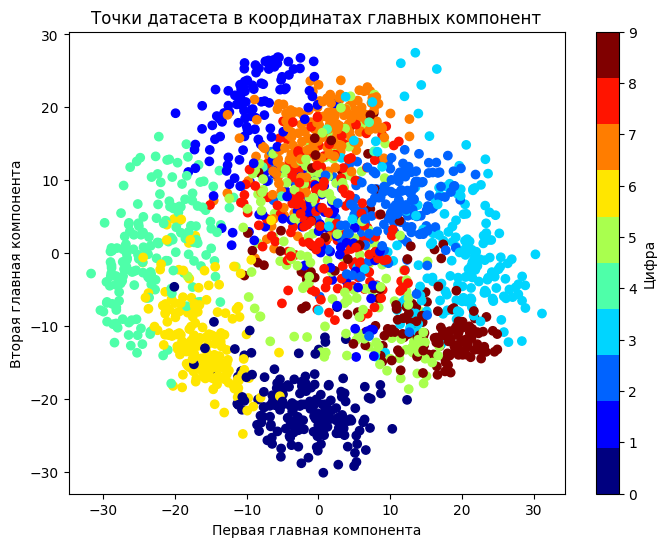

In [32]:
from sklearn.datasets import load_digits

class my_PCA():
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.components = None
        
    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        cov_matrix = np.cov(X_centered.T)

        self.eigenvalues, self.eigenvectors = np.linalg.eig(cov_matrix)
        
        idx = np.argsort(self.eigenvalues)[::-1] 
        self.eigenvalues = self.eigenvalues[idx]
        self.eigenvectors = self.eigenvectors[:, idx]

        self.components = self.eigenvectors[:, :self.n_components]

    def transform(self, X):
        X_centered = X - self.mean
        return np.dot(X_centered, self.components)

    def fit_transform(self, X):
        pass

digits = load_digits()
X = digits.data

pca = my_PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(pca.eigenvalues, 'o-')
plt.xlabel('Номер главной компоненты')
plt.ylabel('Собственное значение')
plt.title('Собственные значения')

plt.subplot(2, 1, 2)
plt.plot(np.cumsum(pca.eigenvalues) / np.sum(pca.eigenvalues))
plt.xlabel('Номер главной компоненты')
plt.ylabel('Доля дисперсии')
plt.title('Кумулятивная сумма собственных значений')
plt.tight_layout()
plt.show()

print(f"Доля дисперсии, покрываемая первыми 15 главными компонентами: {np.sum(pca.eigenvalues[:15]) / np.sum(pca.eigenvalues):.2f}")

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=digits.target, cmap=plt.cm.get_cmap('jet', 10))
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.title('Точки датасета в координатах главных компонент')
plt.colorbar(label='Цифра')
plt.show()

Несмотря на то, что некоторые классы (например, 0 и 1, 3 и 8) в координатах главных компонент выглядят более-менее линейно разделимыми, другие классы (например, 4, 5, 6, 9) сильно перекрываются. Поэтому можно сделать вывод, что линейная разделимость классов в этих координатах ограничена

## III. Алгоритм kNN

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class my_kNN:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = []
        for x in X:
            distances = np.linalg.norm(self.X_train - x, axis=1)
            k_nearest_indices = np.argsort(distances)[:self.n_neighbors]
            k_nearest_labels = self.y_train[k_nearest_indices]
            predicted_label = np.argmax(np.bincount(k_nearest_labels))
            y_pred.append(predicted_label)
        return np.array(y_pred)

digits = load_digits()
X = digits.data
labels = digits.target

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

knn = my_kNN()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность my_kNN (без PCA): {accuracy:.2f}")


best_accuracy = 0
best_n_neighbors = 0
best_n_components = 0

for n_components in range(1, X_train.shape[1] + 1):
    pca = my_PCA(n_components=n_components)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    for n_neighbors in range(1, 31):
        knn = my_kNN(n_neighbors=n_neighbors)
        knn.fit(X_train_pca, y_train)
        y_pred = knn.predict(X_test_pca)
        accuracy = accuracy_score(y_test, y_pred)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_n_neighbors = n_neighbors
            best_n_components = n_components

print(f"Лучшая точность my_kNN с PCA: {best_accuracy:.2f}")
print(f"Лучшее количество соседей: {best_n_neighbors}")
print(f"Лучшее количество главных компонент: {best_n_components}")

Точность my_kNN (без PCA): 0.99
Лучшая точность my_kNN с PCA: 0.99
Лучшее количество соседей: 8
Лучшее количество главных компонент: 15


## Вывод

PCA:
  * Метод главных компонент (PCA) эффективно снижает размерность данных, сохраняя большую часть информации.
  * PCA может улучшить точность классификации, уменьшая влияние шума и делая данные более линейно разделимыми.

kNN:
  * kNN хорошо работает с данными MNIST, но его точность может быть ограничена, если данные нелинейно разделимы. 
  * Использование PCA для уменьшения размерности может значительно повысить точность kNN.